## Creating New Models to Predict AGBD from GEDI Data
This workflow shows an example of creating new models to apply to GEDI data when new field and simulated GEDI data are available. The primary input is a csv file of field and simulated RH metrics (see "Create_AGB_Training_Data_Ghana"), and the outputs are model files that could be applied to on orbit (see "Apply_GEDI_Models_for_Mapping_Ghana").

Note that this workflow is provided as an example only. The actual models applied to on orbit GEDI are provided with the data delivery as rds files, and were created using GEDI's official biomass algorithm fitting workflow which fits and tests thousands of models, and is computationally intensive. This example is a simplified version intended for transparency and understanding of how GEDI's models work.

## Fitting models to predict AGBD from simulated RH metrics
The West African AGBD models predict AGBD as a function of only one wasform metrics, maximum height (RH98), in square root transformed space (to linearize models).

This workflow shows example of a model fit with simulated RH98 metrics and field estimates of AGBD. Simulated GEDI waveform data from airborne laser scanning (ALS) datasets in Ghana span three Plant Functional Types (PFTs).

DBT: Deciduous Broadleaf Froests (MODIS class 4)
EBT: Evergreen Broadleaf Forests (MODIS class 2)
GS: Grasslands & Shrublands (MODIS class 5, 6, 7 and 8)

This resource was developed through the project “Global Transformation of Forests for People and Climate: A Focus on West Africa”; implemented by the Food and Agriculture Organization of the United Nations in partnership with the Economic Community of West African States, the University of Maryland, the University of Oxford, the  Forestry Research Institute of Ghana (FORIG)]; and with financial support from the Swedish International Development Cooperation Agency. 

**Notebook authors:**

Dr. Samuel Grubinger, Geographical Sciences, University of Maryland (sgrubing@umd.edu)

Dr. Laura Duncanson, Geographical Sciences, University of Maryland (lduncans@umd.edu)

Veronika Leitold, Geographical Sciences, University of Maryland (vleitold@umd.edu)

Notebooks were developed at the University of Maryland, College Park, through expansion of existing NASA Global Ecosystem Dynamics Investigation (GEDI) mission activities.

*Code in this notebook is an illustrative example meant to educate users but is not the official GEDI code that was co-developed by Dr. James Kellner, Dr. Laura Duncanson and Dr. John Armston who led the first version of GEDI's footprint level biomass product under the guidance of GEDI PI Dr. Ralph Dubayah.*

**Data Collection:**
Field data were collected and curated by FORIG.

Contact: Dr. Stephen Adu-Bredu, sabredu@csir-forig.org.gh

UAV Lidar data were collected by Oxford University.

Contact: Dr. Jesús Aguirre Gutiérrez, jesus.aguirregutierrez@ouce.ox.ac.uk

In [2]:
library(ggpubr)
library(terra)
library(BIOMASS)
library(ggplot2)
library(sf)
library(tidyverse)

## Open Cal Val Dataset
This opens a csv file similar to the csv file from Create_AGB_Training_Data. However this file includes simulated RH metrics as well as field plot estimated of AGBD (which can be simulated from ALS using the GEDI waveform simulator.

Note there is a lot more data in this csv file than we need. We only use RH98 for model fitting, but many other RH metrics, and products of RH metrics are provided (e.g. RH10 * RH98 is called RH_10_RH_98).

In [ ]:
# load the footprint-level calval data
# as an sf object
calval = read_csv("/projects/shared-buckets/samuel.grubinger/FAO_WestAfrica/GEDICalValSingleFootprintAll_gedicalvaldata_2024ghana05m_project_aggressive_filter.csv") |>
    st_as_sf(coords = c("g.x", "g.y"), crs = 32630) |>
    st_transform(4326)

str(calval)

## Check for Height Discrepancies, Filter Data if Needed
Note that the heights have a 100 m offset, which was intentionally added before model fitting. This is because when fitting models in square root transformed space, negative predictions will be back transformed to positive predictions when squared, leading to overestimated of low AGBD. Therefore we never wanted to have a negative prediction of agbd. We can simply substract 100 from field and simulated RH98 to plot the actual heights. 

In [ ]:
plot(calval$HEIGHT ~ calval$RH_98, xlab='Simulated RH98 (m)', ylab='Field Max Height (m)')
abline (0,1,lty=2,col='red')

In [ ]:
field_height <- calval$HEIGHT-100.0
gedi_height <- calval$RH_98-100.0
plot(field_height ~ gedi_height, xlab='Simulated Max Height (m)', ylab='Field Max Height (m)', xlim=c(0,50), ylim=c(0,50))
abline (0,1,lty=2,col='red')

---

### Create Plots and Maps of Cal Val Data to Check
Typically before fitting models it is a good idea to check the data, both spatially through creating maps and through checking the relationships between field agbd estimates and lidar heights.

If there is a large discrepancy (>10 m) between field measured or modeled height, and RH98, the data are removed from model fitting because there is either a problem with the lidar data, the field data, or both. This is often the case with problematic geolocation. Note that in this example any quality issues with geolocation were sorted out in consultation with the field team, so no data is filtered out below - the data were high quality before the modeling step. But this should always be checked.

In [ ]:
#check for height discrepancies
#pick a threshold tolerance - in this example discrepancies of more than 10 m will be removed
height_threshold <- 10.0
bad_data <- which(abs(calval$HEIGHT-calval$RH_98)>height_threshold)
if(length(bad_data)>1){
    calval <- calval[-bad_data,]
}

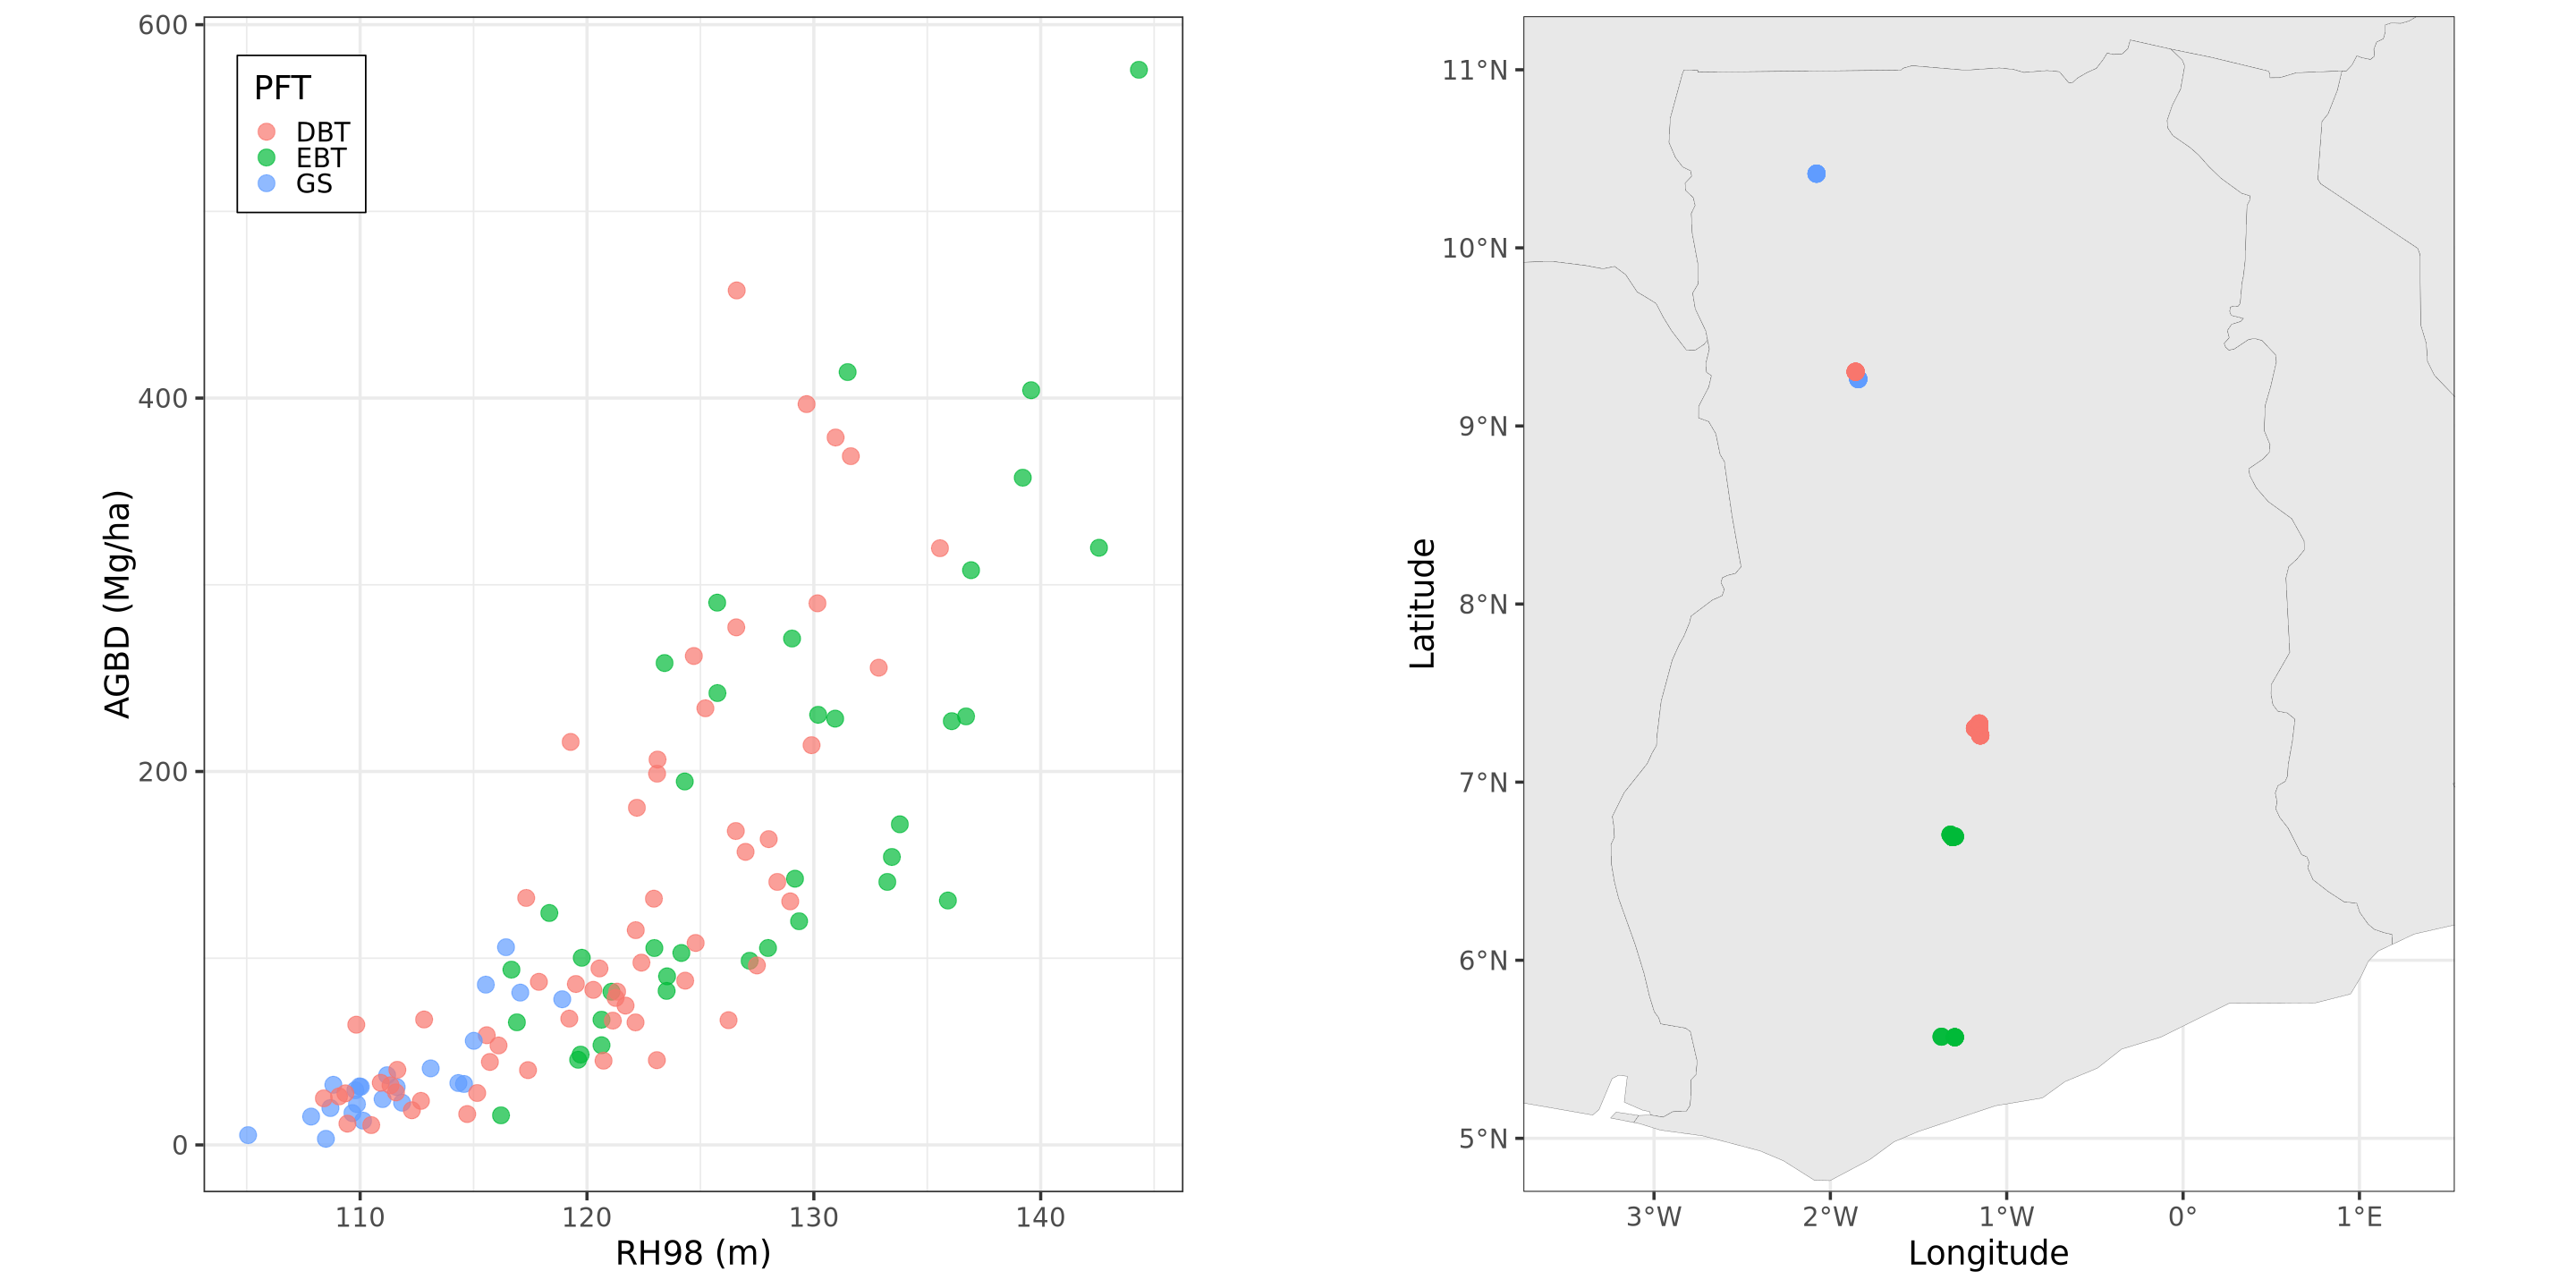

In [5]:
map_obj <- maps::map("world", exact = FALSE, plot = FALSE, fill = TRUE) |>
  sf::st_as_sf()

fig_map <- ggplot() +
    geom_sf(data = map_obj,
			color="#595959", fill="#e8e8e8", linewidth=0.1, alpha=1) +
    geom_sf(data=calval, 
				size=5, alpha=.7, aes(color = PFT)) + 
    theme_bw(base_size = 22) +
    theme(legend.position="none",
                      panel.border=element_rect(colour="black",fill=NA,linewidth=0.5)) +  
				labs(x="Longitude",y="Latitude") + 
        xlim(-3.5,1.3) + ylim(5,11)

# options(repr.plot.width=10)

# plot RH98 vs. AGBD

fig_scatter = calval |>
    ggplot(aes(x = RH_98, y = AGBD)) +
            #geom_abline(slope = 1, linetype = "dashed", color="red3") +
            geom_point(size = 5, 
                       aes(color = PFT),
                       alpha = .7) +
            # geom_smooth(method = "lm", formula = 'y ~ x', se = FALSE, color = "red3") + 
            theme_bw(base_size = 22) +
            theme(aspect.ratio = 1.2,
                 strip.background = element_blank(),
                 legend.position = "inside",
                 legend.position.inside = c(.1, .9),
                 legend.background=element_rect(colour="black",fill="white",linewidth=0.5)) +
            #coord_fixed(ratio = .4) +
            labs(x = "RH98 (m)",
                 y = "AGBD (Mg/ha)") 
# +
#             facet_grid(. ~ PFT)

options(repr.plot.width=24,
       repr.plot.height=12)

fig = ggarrange(fig_scatter, fig_map)

plot(fig)

---

## Fitted models by PFT
GEDI fits models based on Plant Functional Type (PFT) and there were three PFTs available in Ghana, so three models were fit. However, in GEDI's official code many different exhaustive modeling scenarios are considered, including separation of training data into strata, or combining multiple PFTs to fit models that are applied to a single PFT. In the final selected models for West Africa, the best models were found to use training data from all of the PFTs when developing models for DBT and EBT, and only data from the GS strata to fit models for GS (woodland, grassland, shrubland models). 

This example shows fitting separate models to each strata for simplicity. When developing models to apply to on orbit GEDI we recommend doing this in collaboration and consultation with the GEDI mission team. 

An example of a model for each PFT fit with simulated RH98 metrics and field estimates of AGBD. This example predicts the square root transformation of AGBD with the square root transformation of maximum height (RH98) separating the training data by PFT. The model statistics for each of these are shown below.


In [6]:
models_PFT = calval |>
    st_drop_geometry() |>
    group_by(PFT) |>
    tidyr::nest() |>
    # fit the candidate models as list columns with purrr
    mutate(model = purrr::map(data, 
                           ~lm(formula = sqrt(AGBD) ~ 
                                              sqrt(RH_98),
                                              data = .))) |>
    mutate(preds = map2(data, model, modelr::add_predictions)) %>%
      mutate(preds = map(preds, dplyr::select, pred)) %>%
      mutate(resids = map2(data, model, modelr::add_residuals)) %>%
      mutate(resids = map(resids, dplyr::select, resid)) %>%
     mutate(glance = map(model, broom::glance))  %>% 
      # #mutate(rmse_halfnorm = map(model, qpcR::RMSE)) %>%
    dplyr::select(-model) %>%
      unnest(c(data, preds, resids, glance))

#names(models_PFT)

mods_eval = models_PFT
    group_by(PFT) %>%
    summarize(#x_min = min(pred),
              #y_max = max(AGB_per_ha),
            r.squared = round(mean(r.squared), 2),
              Bias = round(mean(resid), 2),
              MAE = round(mean(abs(resid)), 2),
              RMSE = round(sqrt(mean(resid^2)), 2))

mods_eval

PFT,r.squared,Bias,MAE,RMSE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
DBT,0.68,0,2.05,2.58
EBT,0.62,0,2.30,2.70
GS,0.76,0,0.81,1.02


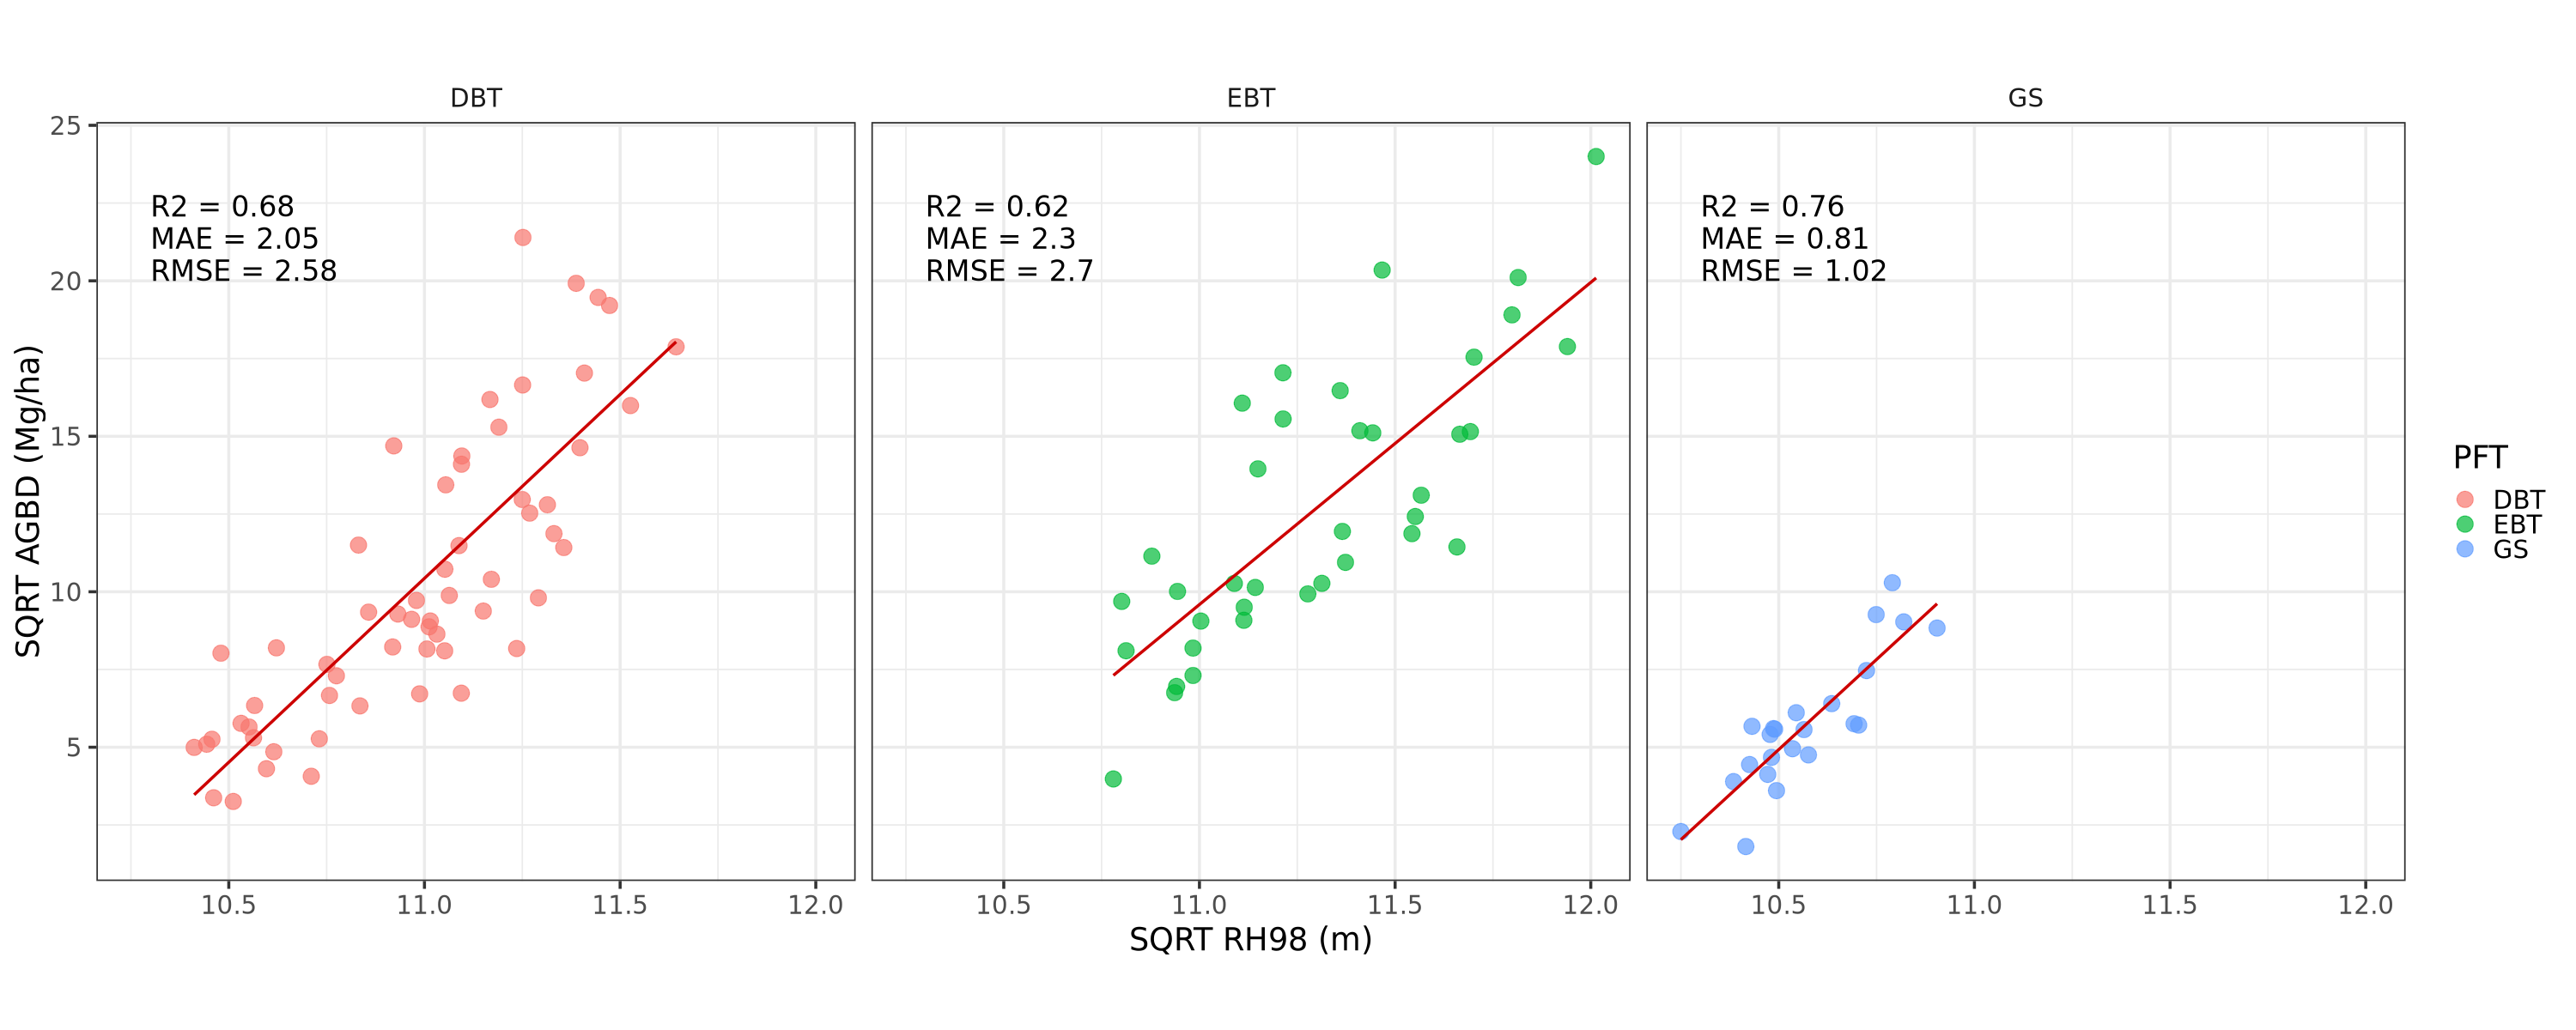

In [7]:
# plot RH98 vs. AGBD

fig = calval |>
    ggplot(aes(x = sqrt(RH_98), y = sqrt(AGBD))) +
            #geom_abline(slope = 1, linetype = "dashed", color="red3") +
            geom_point(size = 5, 
                       aes(color = PFT),
                       alpha = .7) +
            geom_smooth(method = "lm", formula = 'y ~ x', se = FALSE, color = "red3") + 
            geom_text(data = mods_eval,
                      x = 10.3, y = 20,
                      aes(
                      label = paste0('R2 = ', r.squared)),  
                        size = 7,  
                        parse = FALSE,  
                        vjust = -3,  
                        hjust = 0) +
            geom_text(data = mods_eval,
                      x = 10.3, y = 20,
                      aes(
                      label = paste0('MAE = ', MAE)),  
                        size = 7,  
                        parse = FALSE,  
                        vjust = -1.5,  
                        hjust = 0) +
            geom_text(data = mods_eval,
                      x = 10.3, y = 20,
                      aes(
                      label = paste0('RMSE = ', RMSE)),  
                        size = 7,  
                        parse = FALSE,  
                        vjust = 0,  
                        hjust = 0) +
            theme_bw(base_size = 22) +
            # scale_x_continuous(limits = c(50, 770), breaks = seq(100, 700, 200)) +
            # scale_y_continuous(limits = c(50, 770), breaks = seq(100, 700, 200)) +
            theme(aspect.ratio = 1,
                 strip.background = element_blank()) +
            #coord_fixed(ratio = .4) +
            labs(x = "SQRT RH98 (m)",
                 y = "SQRT AGBD (Mg/ha)") +
            facet_grid(. ~ PFT)

options(repr.plot.width=25,
       repr.plot.height=10)
plot(fig)

## Plot Actual Models applied for West Africa AGBD
As mentioned, the models developed above are simple examples. The code to fit the actual models applied is more complicated and computationally intensive. However the final models are very similar to the above. These models are available with the data product, and explored below. Note that the best models for DBT and EBT (deciduous and evergreen forests) are actually identical. These models were fit using all of the Ghana data, and tested on EBT and DBT individually. Therefore they are stored as separate models but are exactly the same model. This can be considered one 'forest' model for Ghana, or West Africa, while the Woodland Grassland Shrubland model is separate and developed using only that PFT.

In [45]:
# load the models from final model fit. Note DBT and EBT are stored separately but are identical models, trained with all the Ghana data
model_DBT = readRDS("/projects/shared-buckets/leitoldv/FAO_WestAfrica/MODELS/predict_DBT_Af_fit_Af_sqrt_sqrt_Snowdon_1.rds")
model_EBT = readRDS("/projects/shared-buckets/leitoldv/FAO_WestAfrica/MODELS/predict_EBT_Af_fit_Af_sqrt_sqrt_Snowdon_1.rds")
model_GS = readRDS("/projects/shared-buckets/leitoldv/FAO_WestAfrica/MODELS/predict_GS_Af_fit_GS_Af_sqrt_sqrt_Snowdon_11.rds")



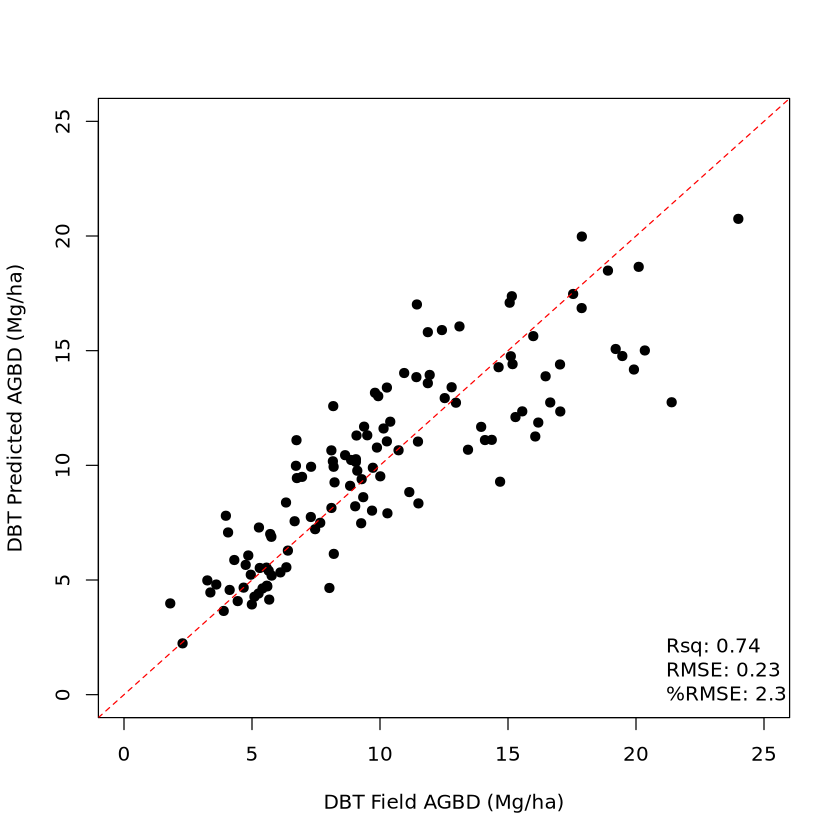

In [46]:
#plot DBT in model fit space (note, this is the same as EBT)
plot(model_DBT$fitted.values ~ model_DBT$model$'sqrt(AGBD)', pch=19, xlim=c(0,25), ylim=c(0,25), xlab='DBT Field AGBD (Mg/ha)', ylab='DBT Predicted AGBD (Mg/ha)')
abline(0,1,lty=2,col='red')
rsq <- round(summary(model_DBT)$r.squared,2)
rmse <- round(summary(model_DBT)$sigma,2)
mean_agbd <- mean(model_DBT$model$'sqrt(AGBD)')
prmse <- round(((rmse/mean_agbd)*100),1)
cex1 <- 1
legend('bottomright', legend=c(paste('Rsq: ', rsq, sep=''), paste('RMSE: ', rmse, sep=''), paste('%RMSE: ', prmse, sep='')), bty='n', cex=cex1)


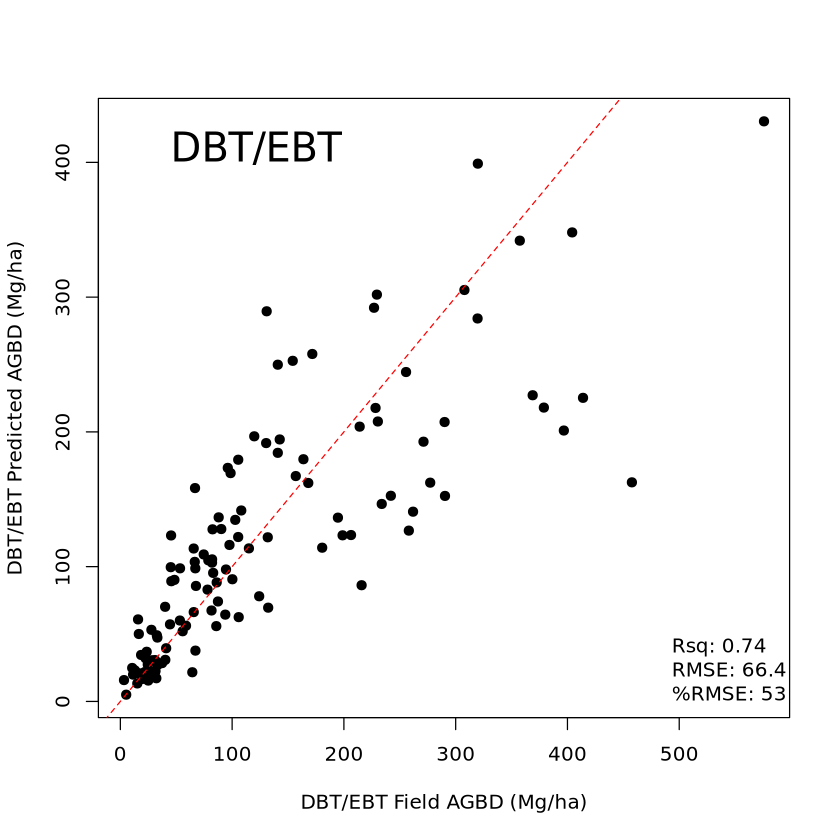

In [47]:
#plot DBT in backtransformed space
field_agbd <- (model_DBT$model$'sqrt(AGBD)')^2
predicted_agbd <- model_DBT$fitted.values^2
plot(predicted_agbd ~ field_agbd, pch=19, xlab='DBT/EBT Field AGBD (Mg/ha)', ylab='DBT/EBT Predicted AGBD (Mg/ha)')
abline(0,1,lty=2,col='red')
rsq <- round(summary(model_DBT)$r.squared,2)
residuals <- predicted_agbd - field_agbd
rmse <- round(sqrt(mean(abs(residuals^2))),2)
mean_agbd <- mean(model_DBT$model$'sqrt(AGBD)'^2)
prmse <- round(((rmse/mean_agbd)*100),1)
cex1 <- 1
legend('bottomright', legend=c(paste('Rsq: ', rsq, sep=''), paste('RMSE: ', rmse, sep=''), paste('%RMSE: ', prmse, sep='')), bty='n', cex=cex1)
legend('topleft', legend='DBT/EBT', cex=2.0, bty='n')

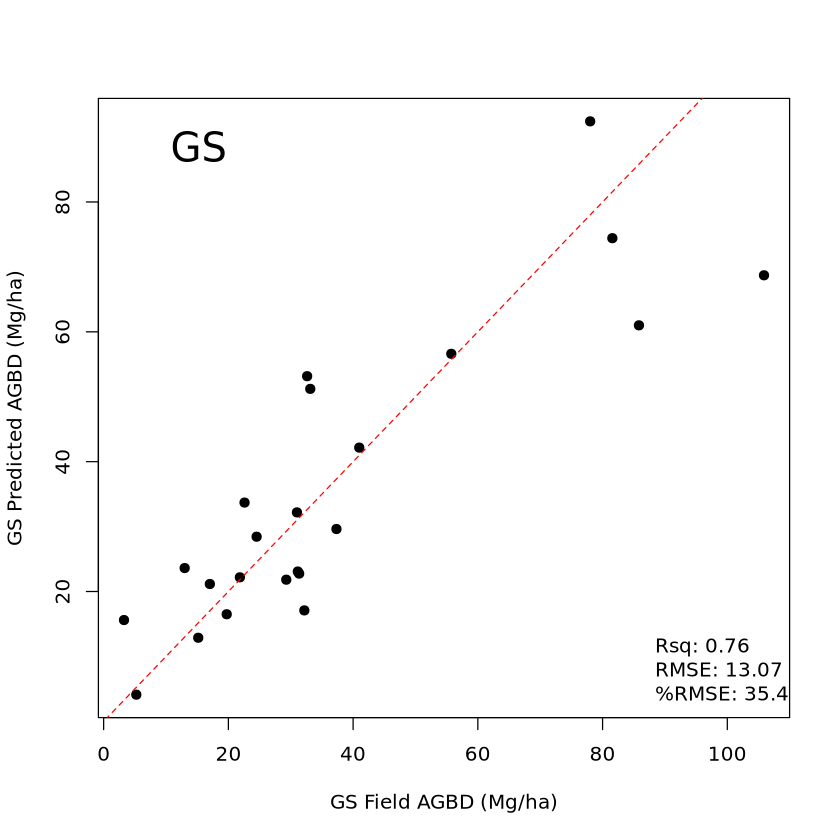

In [48]:
#plot GS in backtransformed space
field_agbd <- (model_GS$model$'sqrt(AGBD)')^2
predicted_agbd <- model_GS$fitted.values^2
plot(predicted_agbd ~ field_agbd, pch=19, xlab='GS Field AGBD (Mg/ha)', ylab='GS Predicted AGBD (Mg/ha)')
abline(0,1,lty=2,col='red')
rsq <- round(summary(model_GS)$r.squared,2)
residuals <- predicted_agbd - field_agbd
rmse <- round(sqrt(mean(abs(residuals^2))),2)
mean_agbd <- mean(model_GS$model$'sqrt(AGBD)'^2)
prmse <- round(((rmse/mean_agbd)*100),1)
cex1 <- 1
legend('bottomright', legend=c(paste('Rsq: ', rsq, sep=''), paste('RMSE: ', rmse, sep=''), paste('%RMSE: ', prmse, sep='')), bty='n', cex=cex1)
legend('topleft', legend='GS', cex=2.0, bty='n')